<a href="https://colab.research.google.com/github/vdopathi1/bioinformatics_final_project/blob/main/Exploratory_Data_Analysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bioinformatics Project - Computational Drug Discovery [Part 2] Exploratory Data Analysis**

Chanin Nantasenamat

[*'Data Professor' YouTube channel*](http://youtube.com/dataprofessor)

In this Jupyter notebook, we will be building a real-life **data science project** that you can include in your **data science portfolio**. Particularly, we will be building a machine learning model using the ChEMBL bioactivity data.

In **Part 2**, we will be performing Descriptor Calculation and Exploratory Data Analysis.

---

## **Install conda and rdkit**

In [1]:
#! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
#! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
#! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
#! conda install -c rdkit rdkit -y
#import sys
#sys.path.append('/usr/local/lib/python3.7/site-packages/')

## **Load bioactivity data**

In [2]:
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('bioactivity_preprocessed_data.csv')
df.head()

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,750.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,100.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,300.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,800.0


## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

### **Import libraries**

In [5]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 41.7 MB/s eta 0:00:00


In [6]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [7]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [11]:
df_lipinski = pd.DataFrame(np.nan, index=df.index, columns=["MW","LogP","NumHDonors","NumHAcceptors"])

valid_smiles_mask = df['canonical_smiles'].apply(lambda x: isinstance(x, str) and pd.notna(x))
valid_smiles_df = df[valid_smiles_mask]

if not valid_smiles_df.empty:
    calculated_lipinski = lipinski(valid_smiles_df.canonical_smiles)
    df_lipinski.loc[valid_smiles_mask, ["MW","LogP","NumHDonors","NumHAcceptors"]] = calculated_lipinski.values

In [9]:
# Initialize an empty DataFrame with NaN values, same index as df
#df_lipinski = pd.DataFrame(np.nan, index=df.index, columns=["MW","LogP","NumHDonors","NumHAcceptors"])

# Identify rows with valid (non-NaN and string type) canonical_smiles
# This ensures that Chem.MolFromSmiles only receives valid SMILES strings.
#valid_smiles_mask = df['canonical_smiles'].apply(lambda x: isinstance(x, str) and pd.notna(x))
#valid_smiles_df = df[valid_smiles_mask]

# Calculate descriptors only for valid SMILES
#if not valid_smiles_df.empty:
#    calculated_lipinski = lipinski(valid_smiles_df.canonical_smiles)

#    # Assign the calculated descriptors back to df_lipinski at the correct indices
#    df_lipinski.loc[valid_smiles_mask, ["MW","LogP","NumHDonors","NumHAcceptors"]] = calculated_lipinski.values

### **Combine DataFrames**

Let's take a look at the 2 DataFrames that will be combined.

In [12]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.8032,0.0,6.0
1,376.913,4.5546,0.0,5.0
2,426.851,5.3574,0.0,5.0
3,404.845,4.7069,0.0,5.0
4,346.334,3.0953,0.0,6.0
...,...,...,...,...
8440,378.944,4.8830,2.0,4.0
8441,406.998,5.5761,1.0,4.0
8442,424.988,5.5257,1.0,4.0
8443,422.013,5.3538,1.0,5.0


In [13]:
df

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,750.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,100.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,300.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,800.0
...,...,...,...,...
8440,CHEMBL5755069,Nc1cc(O)c(C(=O)CCC2CCN(CC3CCCCC3)CC2)cc1Cl,active,411.0
8441,CHEMBL5791030,CCOc1cc(N)c(Cl)cc1C(=O)CCC1CCN(CC2CCCCC2)CC1,active,395.0
8442,CHEMBL5799857,Nc1cc(OCCF)c(C(=O)CCC2CCN(CC3CCCCC3)CC2)cc1Cl,active,625.0
8443,CHEMBL5833354,CON=C(CCC1CCN(CC2CCCCC2)CC1)c1cc(Cl)c(N)cc1OC,active,320.0


Now, let's combine the 2 DataFrame

In [14]:
df_combined = pd.concat([df,df_lipinski], axis=1)

In [15]:
df_combined

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,750.0,312.325,2.8032,0.0,6.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,100.0,376.913,4.5546,0.0,5.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,50000.0,426.851,5.3574,0.0,5.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,300.0,404.845,4.7069,0.0,5.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,800.0,346.334,3.0953,0.0,6.0
...,...,...,...,...,...,...,...,...
8440,CHEMBL5755069,Nc1cc(O)c(C(=O)CCC2CCN(CC3CCCCC3)CC2)cc1Cl,active,411.0,378.944,4.8830,2.0,4.0
8441,CHEMBL5791030,CCOc1cc(N)c(Cl)cc1C(=O)CCC1CCN(CC2CCCCC2)CC1,active,395.0,406.998,5.5761,1.0,4.0
8442,CHEMBL5799857,Nc1cc(OCCF)c(C(=O)CCC2CCN(CC3CCCCC3)CC2)cc1Cl,active,625.0,424.988,5.5257,1.0,4.0
8443,CHEMBL5833354,CON=C(CCC1CCN(CC2CCCCC2)CC1)c1cc(Cl)c(N)cc1OC,active,320.0,422.013,5.3538,1.0,5.0


### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [16]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis=1)

    return x

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [17]:
df_combined.standard_value.describe()

,standard_value
count,8.445000e+03
mean,9.298928e+04
std,9.655942e+05
min,0.000000e+00
25%,1.000000e+02
50%,1.460000e+03
75%,1.181000e+04
max,5.000000e+07


In [18]:
-np.log10( (10**-9)* 100000000 )

np.float64(1.0)

In [19]:
-np.log10( (10**-9)* 10000000000 )

np.float64(-1.0)

In [20]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis=1)

    return x

We will first apply the norm_value() function so that the values in the standard_value column is normalized.

In [21]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,750.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,100.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,300.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,800.0
...,...,...,...,...,...,...,...,...
8440,CHEMBL5755069,Nc1cc(O)c(C(=O)CCC2CCN(CC3CCCCC3)CC2)cc1Cl,active,378.944,4.8830,2.0,4.0,411.0
8441,CHEMBL5791030,CCOc1cc(N)c(Cl)cc1C(=O)CCC1CCN(CC2CCCCC2)CC1,active,406.998,5.5761,1.0,4.0,395.0
8442,CHEMBL5799857,Nc1cc(OCCF)c(C(=O)CCC2CCN(CC3CCCCC3)CC2)cc1Cl,active,424.988,5.5257,1.0,4.0,625.0
8443,CHEMBL5833354,CON=C(CCC1CCN(CC2CCCCC2)CC1)c1cc(Cl)c(N)cc1OC,active,422.013,5.3538,1.0,5.0,320.0


In [22]:
df_norm.standard_value_norm.describe()

,standard_value_norm
count,8.445000e+03
mean,9.298928e+04
std,9.655942e+05
min,0.000000e+00
25%,1.000000e+02
50%,1.460000e+03
75%,1.181000e+04
max,5.000000e+07


In [23]:
df_final = pIC50(df_norm)
df_final

/tmp/ipython-input-3997281295.py:10: RuntimeWarning: divide by zero encountered in log10
  pIC50.append(-np.log10(molar))


,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
8440,CHEMBL5755069,Nc1cc(O)c(C(=O)CCC2CCN(CC3CCCCC3)CC2)cc1Cl,active,378.944,4.8830,2.0,4.0,6.386158
8441,CHEMBL5791030,CCOc1cc(N)c(Cl)cc1C(=O)CCC1CCN(CC2CCCCC2)CC1,active,406.998,5.5761,1.0,4.0,6.403403
8442,CHEMBL5799857,Nc1cc(OCCF)c(C(=O)CCC2CCN(CC3CCCCC3)CC2)cc1Cl,active,424.988,5.5257,1.0,4.0,6.204120
8443,CHEMBL5833354,CON=C(CCC1CCN(CC2CCCCC2)CC1)c1cc(Cl)c(N)cc1OC,active,422.013,5.3538,1.0,5.0,6.494850


In [24]:
df_final.pIC50.describe()

,pIC50
count,8445.000000
mean,inf
std,NaN
min,1.301030
25%,4.927750
50%,5.835647
75%,7.000000
max,inf


### **Removing the 'intermediate' bioactivity class**
Here, we will be removing the ``intermediate`` class from our data set.

In [25]:
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
8440,CHEMBL5755069,Nc1cc(O)c(C(=O)CCC2CCN(CC3CCCCC3)CC2)cc1Cl,active,378.944,4.8830,2.0,4.0,6.386158
8441,CHEMBL5791030,CCOc1cc(N)c(Cl)cc1C(=O)CCC1CCN(CC2CCCCC2)CC1,active,406.998,5.5761,1.0,4.0,6.403403
8442,CHEMBL5799857,Nc1cc(OCCF)c(C(=O)CCC2CCN(CC3CCCCC3)CC2)cc1Cl,active,424.988,5.5257,1.0,4.0,6.204120
8443,CHEMBL5833354,CON=C(CCC1CCN(CC2CCCCC2)CC1)c1cc(Cl)c(N)cc1OC,active,422.013,5.3538,1.0,5.0,6.494850


---

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

### **Import library**

In [26]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 bioactivity classes**

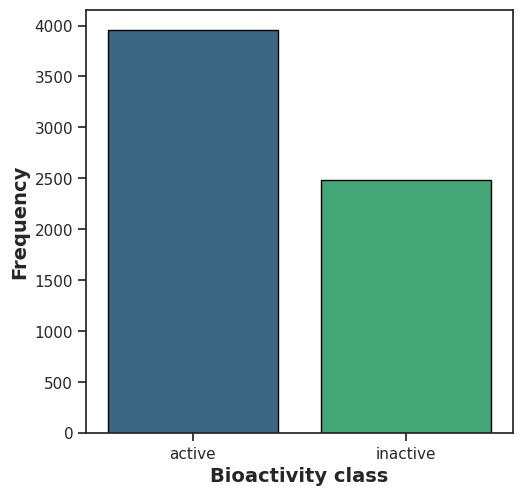

In [27]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', hue='bioactivity_class', data=df_2class, edgecolor='black', palette='viridis', legend=False)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

In [ ]:
plt.figure(figsize=(5.5, 5.5))

# Filter out non-finite pIC50 values before plotting
df_plot = df_2class[np.isfinite(df_2class['pIC50'])].copy()

sns.scatterplot(x='MW', y='LogP', data=df_plot, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

/usr/local/lib/python3.12/dist-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
/usr/local/lib/python3.12/dist-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


ValueError: Can only output finite numbers in PDF

### **Box plots**

#### **pIC50 value**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('pIC50')

#### **MW**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

#### **LogP**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
mannwhitney('LogP')

#### **NumHDonors**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
mannwhitney('NumHDonors')

#### **NumHAcceptors**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [ ]:
mannwhitney('NumHAcceptors')

#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

Of the 4 Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors), only LogP exhibited ***no difference*** between the **actives** and **inactives** while the other 3 descriptors (MW, NumHDonors and NumHAcceptors) shows ***statistically significant difference*** between **actives** and **inactives**.

## **Zip files**

In [ ]:
! zip -r results.zip . -i *.csv *.pdf